# Predicting house prices using k-nearest neighbors regression

# Imports

In [32]:
import graphlab
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Load in house sales data

For this notebook, we use a subset of the King County housing dataset created by randomly selecting 40% of the houses in the full dataset.

In [2]:
sales = graphlab.SFrame('kc_house_data_small.gl/')

2016-05-28 18:40:32,582 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.9 started. Logging: /tmp/graphlab_server_1464475230.log


This non-commercial license of GraphLab Create is assigned to damiansp@gmail.com and will expire on March 07, 2017. For commercial licensing options, visit https://dato.com/buy/.


# Copy useful functions from previous notebooks

In [3]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 
    features = ['constant'] + features 
    features_sframe = data_sframe[features]
    print features_sframe.head()

    feature_matrix = features_sframe.to_numpy()
    output_sarray = data_sframe[output]

    output_array = output_sarray.to_numpy()

    return(feature_matrix, output_array)

In [4]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis = 0)
    normalized_features = feature_matrix / norms
    return (normalized_features, norms)

# Split data into training, test, and validation sets

In [5]:
(train_and_validation, test) = sales.random_split(0.8, seed = 1) 
(train, validation) = train_and_validation.random_split(0.8, seed = 1)

# Extract features and normalize

In [6]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

+----------+----------+-----------+-------------+----------+--------+------------+
| constant | bedrooms | bathrooms | sqft_living | sqft_lot | floors | waterfront |
+----------+----------+-----------+-------------+----------+--------+------------+
|    1     |   3.0    |    1.0    |    1180.0   |   5650   |  1.0   |     0      |
|    1     |   3.0    |    2.25   |    2570.0   |   7242   |  2.0   |     0      |
|    1     |   2.0    |    1.0    |    770.0    |  10000   |  1.0   |     0      |
|    1     |   4.0    |    3.0    |    1960.0   |   5000   |  1.0   |     0      |
|    1     |   3.0    |    2.0    |    1680.0   |   8080   |  1.0   |     0      |
|    1     |   3.0    |    1.5    |    1060.0   |   9711   |  1.0   |     0      |
|    1     |   3.0    |    1.0    |    1780.0   |   7470   |  1.0   |     0      |
|    1     |   3.0    |    2.5    |    3560.0   |   9796   |  1.0   |     0      |
|    1     |   3.0    |    1.75   |    2450.0   |   2691   |  2.0   |     0      |
|   

# Normalize

In [7]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

# Compute a single distance

Compute the "distance" between two given houses.  Take the **query house** to be the first house of the test set and look at the distance between it and the 10th house of the training set.

In [8]:
print features_test[0]
# Same as:
# print features_test[0, :]

[ 0.01345102  0.01551285  0.01807473  0.01759212  0.00160518  0.017059    0.
  0.05102365  0.0116321   0.01564352  0.01362084  0.02481682  0.01350306
  0.          0.01345386 -0.01346927  0.01375926  0.0016225 ]


In [9]:
features_train[9]

array([ 0.01345102,  0.01163464,  0.00602491,  0.0083488 ,  0.00050756,
        0.01279425,  0.        ,  0.        ,  0.01938684,  0.01390535,
        0.0096309 ,  0.        ,  0.01302544,  0.        ,  0.01346821,
       -0.01346254,  0.01195898,  0.00156612])

In [13]:
def dist_euclidean(v1, v2):
    '''Return the Euclidean distance between two vectors, v1 and v2'''
    return np.sqrt(sum((v1 - v2) ** 2))
    # return np.sqrt(sum([(a - b) ** 2 for (a, b) in zip(v1, v2)]))

# Compute multiple distances

To do nearest neighbor regression, compute the distance between our query house and *all* houses in the training set.  

To visualize this nearest-neighbor search, let's first compute the distance from our query house (`features_test[0]`) to the first 10 houses of the training set (`features_train[0:10]`) and then search for the nearest neighbor within this small set of houses.  With this small set of houses, visually scan the list of 10 distances to verify that the code for finding the nearest neighbor is working.

In [15]:
first10dists = []
for v in features_train[0:10]:
    first10dists.append(dist_euclidean(features_test[0], v))

for d in first10dists:
    print d

0.060274709173
0.0854688114883
0.0614994643712
0.0534027397882
0.0584448406394
0.0598792151018
0.0546314049726
0.0554310832416
0.052383627841
0.0597235937167


In [16]:
print 'min dist:', min(first10dists)
min_index = first10dists.index(min(first10dists))
print 'index:', min_index, '( house:', min_index + 1, ')'

min dist: 0.052383627841
index: 8 ( house: 9 )


It is computationally inefficient to loop over computing distances to all houses in our training dataset. Fortunately, many of the numpy functions can be **vectorized**, applying the same operation over multiple values or vectors.

# Perform 1-nearest neighbor regression

Now that we have the element-wise differences, it is not too hard to compute the Euclidean distances between our query house and all of the training houses. 

In [18]:
def get_all_euclidean_distances(feature_matrix, query_vector):
    return np.sqrt(np.sum((feature_matrix[:] - query_vector) ** 2, axis = 1))

# test
get_all_euclidean_distances(features_train, features_test[0])[100]

0.023708232449603735

In [20]:
house2_dists = get_all_euclidean_distances(features_train, features_test[2])
best = min(house2_dists)
best_index = np.where(house2_dists == best)
print 'Index of nearest neighbor:', best_index
print 'distance:', house2_dists[best_index]

Index of nearest neighbor: (array([382]),)
distance: [ 0.0028605]


In [22]:
# Price (response variable) of the nearest neighbor
output_train[best_index]

array([249000])

# Perform k-nearest neighbor regression

For k-nearest neighbors, find a *set* of k houses in the training set closest to a given query house. Then make predictions based on these k nearest neighbors.

## Fetch k-nearest neighbors

In [24]:
def get_knn(k, feature_matrix, query_vector):
    distances = get_all_euclidean_distances(feature_matrix, query_vector)
    sort_indices = np.argsort(distances)
    return sort_indices[:k]

# test
get_knn(3, features_train, features_test[2])

array([ 382, 1149, 4087])

In [25]:
get_knn(4, features_train, features_test[2])

array([ 382, 1149, 4087, 3142])

## Make a single prediction by averaging k nearest neighbor outputs

A function that predicts the value of a given query house. **For simplicity, the prediction here is the average of the prices of the k nearest neighbors in the training set**. More interesting models can use a kernel-based estimate from the k nearest neighbors.

In [26]:
def knn_predict(k, feature_matrix, Y, query_vector):
    nn = get_knn(k, feature_matrix, query_vector)
    prices = Y[nn]
    return np.mean(prices)

In [27]:
knn_predict(4, features_train, output_train, features_test[2])

413987.5

Compare this predicted value using 4-nearest neighbors to the predicted value using 1-nearest neighbor computed earlier.

## Make multiple predictions

Function to predict the value of *each and every* house in a query set. 

In [28]:
def get_knn_for_all(k, feature_matrix, Y, query_vectors):
    predictions = []
    
    for qv in query_vectors:
        pred = knn_predict(k, feature_matrix, Y, qv)
        predictions.append(pred)
        
    return predictions

In [31]:
# Predict prices for the first 10 houses in features_test
get_knn_for_all(10, features_train, output_train, features_test[:10])

[881300.0,
 431860.0,
 460595.0,
 430200.0,
 766750.0,
 667420.0,
 350032.0,
 512800.70000000001,
 484000.0,
 457235.0]

## Choosing the best value of k using a validation set

Choosing the value of k to use in making predictions using a validation set.

(Depending on your computing environment, this computation may take 10-15 minutes.)

To visualize the performance as a function of `k`, plot the RSS on the VALIDATION set for each considered `k` value:

In [47]:
kvals = range(1, 16)
rss_all = []

for k in kvals:
    preds = get_knn_for_all(k, features_train, output_train, features_valid)
    error = preds - output_valid
    rss = sum(error ** 2)
    rss_all.append(rss)

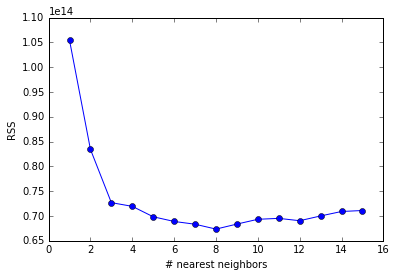

In [48]:
plt.plot(kvals, rss_all,'bo-')
plt.xlabel('# nearest neighbors')
plt.ylabel('RSS')

In [49]:
pred_test = get_knn_for_all(8, features_train, output_train, features_test[:])

In [50]:
error = pred_test - output_test
rss = sum(error ** 2)
rss

133118823551516.81

RSS for the test set with the best *k* from the validation: 1.33e14